# COMP7404 Computational intelligence and machine learning

# Group Project - Peer Teaching - Demo

# Detailed Instructions - Preparations need to be done before running demo

#### 1. download GroupProject_GroupN.zip from GitHub and unzip it

#### 2. go to the link below and download MHEALTHDATASET.zip
#### http://archive.ics.uci.edu/ml/machine-learning-databases/00319/

#### 3. unzip  MHEALTHDATASET.zip, then copy all 10 data files (mHealth_subjectX.log where X from 1 to 10) to the folder "GroupProject_GroupN"

#### 4. make sure packages including numpy, scipy, fastdtw, collections, plyfile, mpl_toolkits.mplot3d, matplotlib and sklearn are installed

#### 5. Python 3.6 is used

#### 6. go to GroupProject_GroupN folder and open jupyter notebook named "Wearable Devices using Dynamic Time Warping.ipynb" to run the demo



# Classes have been designed to manage datasets and algorithm logic
## superclass: dataset

### subclass:trainset
### subclass:testset
### subclass:masterset
    
## superclass: Experiment
### subclass:DTWExperiment

In [57]:
import pandas as pd
import math

class dataset(object):
    def __init__(self, data):
        self._data = data
    
    def get_data(self):
        return self._data
    
    def get_data_by_rows(self, no_of_rows):
        return self._data[0:no_of_rows]
    
    
    def data_cleaning(self):
        
#         print('before dropping na', self._data.shape)
#         self._data.dropna(axis = 0, how='any', inplace = True)
#         print('after dropping na', self._data.shape)
        
        print('before cleaning', self._data.Label.unique())
        self._data = self._data[self._data['Label'] != 0]
        print('after cleaning', self._data.Label.unique())


        
    def data_selected_features(self, selectedFeatures):
        print('before features selected', self._data.columns.unique())
        self._data = self._data[selectedFeatures]
        print('after features selected', self._data.columns.unique())
        
    
    def data_selected_labels(self, selectedLabels):
        print('before labels selected', self._data.Label.unique())
        self._data = self._data[self._data['Label'].isin(selectedLabels)]
        print('after labels selected', self._data.Label.unique())

        
    def get_selected_labels(self):
        return self._data['Label'].unique()
    
    def get_selected_subjects(self):
        return self._data['Subject'].unique()
    
    
    def get_XY(self):
        X = self._data.drop(['Label','Subject'], axis = 1)
        Y = self._data['Label']
        
        return X, Y
    
    def get_X_by_subject_label(self, subject, label, no_of_rows):
        X = self._data[(self._data['Subject']==subject) & (self._data['Label']==label)][0:no_of_rows]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_X_by_subject_label(self, subject, label, subsample):
        X = self._data[(self._data['Subject']==subject) & (self._data['Label']==label)][::subsample]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_X_by_label(self, label, no_of_rows):
        X = self._data[self._data['Label']==label][0:no_of_rows]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_X_by_label(self, label, subsample):
        X = self._data[self._data['Label']==label][::subsample]
        X = X.drop(['Label','Subject'], axis = 1)

        return X
    
    def get_subject(self):
        return self._data['Subject']
    
    def set_data(self, data):
        self._data = data
    
#     def exportToCSV(self, file_name):
#         self._data.to_csv(file_name, index = False)
    
    
    def addThetaColumns(self, columnName):
        thetaXZ, thetaYZ = self.getThetaColumns(columnName)
        self._data[columnName + 'ThetaXZ'] = thetaXZ
        self._data[columnName + 'ThetaYZ'] = thetaYZ
        
    def addAllThetaColumns(self):
        self.addThetaColumns('AccelerationChest')
        self.addThetaColumns('AccelerationAnkle')
        self.addThetaColumns('GyroAnkle')
        self.addThetaColumns('MagnetometerAnkle')
        self.addThetaColumns('AccelerationArm')
        self.addThetaColumns('GyroArm')
        self.addThetaColumns('MagnetometerArm')
        
    
    def getThetaColumns(self, columnName):
        thetaXZ = []
        thetaYZ = []
        for row in range(0, self.get_data().shape[0]):
#             print(row)
            x = self.get_data()[columnName + 'X'].iloc[row]
            y = self.get_data()[columnName + 'Y'].iloc[row]
            z = self.get_data()[columnName + 'Z'].iloc[row]
            
            
#             print(x)
#             print(y)
#             print(z)
            
            tempThetaXZ, tempThetaYZ = self.convertToAngles(x, y, z)
            thetaXZ.append(tempThetaXZ)
            thetaYZ.append(tempThetaYZ)
#             print(thetaXZ[row])
#             print(thetaYZ[row])
        
        return thetaXZ, thetaYZ
    
# = ["AccelerationChestX"
# , "AccelerationChestY"
# , "AccelerationChestZ"
# , "ElectrocardiogramLead1"
# , "ElectrocardiogramLead2"
# , "AccelerationAnkleX"
# , "AccelerationAnkleY"
# , "AccelerationAnkleZ"
# , "GyroAnkleX"
# , "GyroAnkleY"
# , "GyroAnkleZ"
#                 , "MagnetometerAnkleX"
#                 , "MagnetometerAnkleY"
#                 , "MagnetometerAnkleZ"
# , "AccelerationArmX"
# , "AccelerationArmY"
# , "AccelerationArmZ"
# , "GyroArmX"
# , "GyroArmY"
# , "GyroArmZ"
# , "MagnetometerArmX"
# , "MagnetometerArmY"
# , "MagnetometerArmZ"
# , "Label"
# ]

    def unit_vector(self, vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)

    
    def angle_between(self, v1, v2):
        """ Returns the angle in radians between vectors 'v1' and 'v2'::

                >>> angle_between((1, 0, 0), (0, 1, 0))
                1.5707963267948966
                >>> angle_between((1, 0, 0), (1, 0, 0))
                0.0
                >>> angle_between((1, 0, 0), (-1, 0, 0))
                3.141592653589793
        """
        v1_u = self.unit_vector(v1)
        v2_u = self.unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    
    def convertToAngles(self, x, y, z):
        # X-Z Plane, v2.Y must be zero
        v1 = [x, y, z]
        v2 = [x, 0, z]

        if y >= 0 and z >= 0:
            thetaXZ = math.degrees(self.angle_between(v1, v2))
        elif y >= 0 and z <= 0:
            thetaXZ = 180 - math.degrees(self.angle_between(v1, v2))   
        elif y <= 0 and z <= 0:
            thetaXZ = 180 + math.degrees(self.angle_between(v1, v2))
        elif y <= 0 and z >= 0:
            thetaXZ = 360 - math.degrees(self.angle_between(v1, v2))


        # Y-Z Plane, v2.X must be zero
        v1 = [x, y, z]
        v2 = [0, y, z]

        if x >= 0 and z >= 0:
            thetaYZ = math.degrees(self.angle_between(v1, v2))
        elif x >= 0 and z <= 0:
            thetaYZ = 180 - math.degrees(self.angle_between(v1, v2))   
        elif x <= 0 and z <= 0:
            thetaYZ = 180 + math.degrees(self.angle_between(v1, v2))
        elif x <= 0 and z >= 0:
            thetaYZ = 360 - math.degrees(self.angle_between(v1, v2))

        return thetaXZ, thetaYZ

In [58]:
class trainset(dataset):
    def __init__(self):
        
        for i in range(1, 9):
            subject = pd.read_csv('mHealth_subject' + str(i) + '.log', sep="\t", header=None)
            subject.columns = ["AccelerationChestX"
                            , "AccelerationChestY"
                            , "AccelerationChestZ"
                            , "ElectrocardiogramLead1"
                            , "ElectrocardiogramLead2"
                            , "AccelerationAnkleX"
                            , "AccelerationAnkleY"
                            , "AccelerationAnkleZ"
                            , "GyroAnkleX"
                            , "GyroAnkleY"
                            , "GyroAnkleZ"
                            , "MagnetometerAnkleX"
                            , "MagnetometerAnkleY"
                            , "MagnetometerAnkleZ"
                            , "AccelerationArmX"
                            , "AccelerationArmY"
                            , "AccelerationArmZ"
                            , "GyroArmX"
                            , "GyroArmY"
                            , "GyroArmZ"
                            , "MagnetometerArmX"
                            , "MagnetometerArmY"
                            , "MagnetometerArmZ"
                            , "Label"
                           ]

            print(i)
            if i == 1:
                subject['Subject'] = i
                train_subjects = subject
            else:
                subject['Subject'] = i
                train_subjects = pd.concat([train_subjects, subject])

        
        
        super().__init__(train_subjects)

In [59]:
class testset(dataset):
    def __init__(self, subject_index_list):
        count = 0
        for i in subject_index_list:
            count = count + 1
            subject = pd.read_csv('mHealth_subject' + str(i) + '.log', sep="\t", header=None)
            subject.columns = ["AccelerationChestX"
                            , "AccelerationChestY"
                            , "AccelerationChestZ"
                            , "ElectrocardiogramLead1"
                            , "ElectrocardiogramLead2"
                            , "AccelerationAnkleX"
                            , "AccelerationAnkleY"
                            , "AccelerationAnkleZ"
                            , "GyroAnkleX"
                            , "GyroAnkleY"
                            , "GyroAnkleZ"
                            , "MagnetometerAnkleX"
                            , "MagnetometerAnkleY"
                            , "MagnetometerAnkleZ"
                            , "AccelerationArmX"
                            , "AccelerationArmY"
                            , "AccelerationArmZ"
                            , "GyroArmX"
                            , "GyroArmY"
                            , "GyroArmZ"
                            , "MagnetometerArmX"
                            , "MagnetometerArmY"
                            , "MagnetometerArmZ"
                            , "Label"
                           ]

            print(i)
            subject['Subject'] = i
            
            if count == 1:    
                test_subjects = subject
            else:
                test_subjects = pd.concat([test_subjects, subject])
        
            
        super().__init__(test_subjects)

In [60]:
class masterset(dataset):
    def __init__(self, subject_index_list):
        count = 0
        for i in subject_index_list:
            count = count + 1
            subject = pd.read_csv('mHealth_subject' + str(i) + '.log', sep="\t", header=None)
            subject.columns = ["AccelerationChestX"
                            , "AccelerationChestY"
                            , "AccelerationChestZ"
                            , "ElectrocardiogramLead1"
                            , "ElectrocardiogramLead2"
                            , "AccelerationAnkleX"
                            , "AccelerationAnkleY"
                            , "AccelerationAnkleZ"
                            , "GyroAnkleX"
                            , "GyroAnkleY"
                            , "GyroAnkleZ"
                            , "MagnetometerAnkleX"
                            , "MagnetometerAnkleY"
                            , "MagnetometerAnkleZ"
                            , "AccelerationArmX"
                            , "AccelerationArmY"
                            , "AccelerationArmZ"
                            , "GyroArmX"
                            , "GyroArmY"
                            , "GyroArmZ"
                            , "MagnetometerArmX"
                            , "MagnetometerArmY"
                            , "MagnetometerArmZ"
                            , "Label"
                           ]

            
            print(i)
            subject['Subject'] = i

            if count == 1:
                train_subjects = subject
            else:
                train_subjects = pd.concat([train_subjects, subject])

        super().__init__(train_subjects)

In [61]:
class exportset(dataset):
    def __init__(self, subject_index):
        
#         for i in range(1, 9):
        subject = pd.read_csv('mHealth_subject' + str(subject_index) + '.log', sep="\t", header=None)
        subject.columns = ["AccelerationChestX"
                        , "AccelerationChestY"
                        , "AccelerationChestZ"
                        , "ElectrocardiogramLead1"
                        , "ElectrocardiogramLead2"
                        , "AccelerationAnkleX"
                        , "AccelerationAnkleY"
                        , "AccelerationAnkleZ"
                        , "GyroAnkleX"
                        , "GyroAnkleY"
                        , "GyroAnkleZ"
                        , "MagnetometerAnkleX"
                        , "MagnetometerAnkleY"
                        , "MagnetometerAnkleZ"
                        , "AccelerationArmX"
                        , "AccelerationArmY"
                        , "AccelerationArmZ"
                        , "GyroArmX"
                        , "GyroArmY"
                        , "GyroArmZ"
                        , "MagnetometerArmX"
                        , "MagnetometerArmY"
                        , "MagnetometerArmZ"
                        , "Label"
                       ]

#             print(i)
#             if i == 1:
        subject['Subject'] = subject_index
        train_subjects = subject
#             else:
#                 subject['Subject'] = i
#                 train_subjects = pd.concat([train_subjects, subject])

        super().__init__(train_subjects)

In [62]:
class importset(dataset):
    def __init__(self, subject_index_list):
        
        count = 0
        for i in subject_index_list:
            print('importing subject = ', i)
            count = count + 1
            subject = pd.read_csv('subject' + str(i) + '.csv')

            if count == 1:
                train_subjects = subject
            else:
                train_subjects = pd.concat([train_subjects, subject])

        super().__init__(train_subjects)

In [63]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Experiment(object):
    def __init__(self, masterset, testset):
        self._masterset = masterset
        self._testset = testset
        self._masterset_copy = masterset
        self._testset_copy = testset
        
    def restoringDataset(self):
        self._masterset = self._masterset_copy
        self._testset = self._testset_copy
    
    def get_masterset(self):
        return self._masterset
    
    def get_testset(self):
        return self._testset
    
    def Scaling(self, preprocessor):
        X_train, y_train = self._masterset.get_XY()
        X_test, y_test = self._testset.get_XY()
        
        preprocessor.fit(X_train)
        
        X_train_scaled = pd.DataFrame(preprocessor.transform(X_train))
        X_test_scaled = pd.DataFrame(preprocessor.transform(X_test))
        
        X_train_scaled.columns = list(self._masterset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
        X_test_scaled.columns = list(self._testset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
        
        print(X_train_scaled.shape)
        print(self._masterset.get_subject().shape)
        X_train_scaled['Subject'] = list(self._masterset.get_subject())
        X_train_scaled['Label'] = list(y_train)
        
        self._masterset.set_data(X_train_scaled)
        self._masterset.get_data()
        
        X_test_scaled['Subject'] = list(self._testset.get_subject())
        X_test_scaled['Label'] = list(y_test)
        
        self._testset.set_data(X_test_scaled)
        self._testset.get_data()
    
    
    
    def doPCA(self, data, dimensions=2):

        model = PCA(n_components=dimensions)
        model.fit(data)
        print(model.explained_variance_ratio_)
        print(model.explained_variance_)
        print ("Cummulative Variance Explained = ", (np.sum(model.explained_variance_ratio_)))

        print(model.explained_variance_)

        plt.plot(np.cumsum(model.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance');
        
        
        suggestedDimensions = 0
        for suggestedDimensions in range(0, len(model.explained_variance_)):
            if model.explained_variance_[suggestedDimensions] >= 1:
                suggestedDimensions = suggestedDimensions + 1
                print('suggestedDimensions',suggestedDimensions)
            else:
                suggestedDimensions = suggestedDimensions - 1
                print('suggestedDimensions',suggestedDimensions)
                break

        # print "Suggested Dimensions = %d" % suggestedDimensions

        return suggestedDimensions, model
    
    
    
    def ReducingDimensionByPCA(self):
        X_train, y_train = self._masterset.get_XY()
        X_test, y_test = self._testset.get_XY()
        
        suggestedDimensions, pca = self.doPCA(data = X_train, dimensions = X_train.shape[1])
        suggestedDimensions, pca = self.doPCA(data = X_train, dimensions = suggestedDimensions)
        
        X_train_trans = pd.DataFrame(pca.transform(X_train))
        X_test_trans = pd.DataFrame(pca.transform(X_test))
        
#         preprocessor.fit(X_train)
        
#         X_train_scaled = pd.DataFrame(preprocessor.transform(X_train))
#         X_test_scaled = pd.DataFrame(preprocessor.transform(X_test))
        
#         X_train_scaled.columns = list(self._masterset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
#         X_test_scaled.columns = list(self._testset.get_data().drop(['Label','Subject'], axis = 1).columns.values)
        
    
        print(X_train_trans.shape)
        print(self._masterset.get_subject().shape)
        X_train_trans['Subject'] = list(self._masterset.get_subject())
        X_train_trans['Label'] = list(y_train)
        
        self._masterset.set_data(X_train_trans)
        self._masterset.get_data()
        
        X_test_trans['Subject'] = list(self._testset.get_subject())
        X_test_trans['Label'] = list(y_test)
        
        self._testset.set_data(X_test_trans)
        self._testset.get_data()
    
    

In [64]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from collections import Counter


class DTWExperiment(Experiment):
    def __init__(self, master, test):
        super().__init__(master, test)
        
    def classifyOneMovementWithoutSelectMasterSubject(self, testsubject_index, testsubject_action_index, subsample):
        dtw_result = []
#         no_of_rows = 10000
#         testsubject_action_index = 10

        for master_action_index in range(1, 13):
            X_master = self._masterset.get_X_by_label(master_action_index, subsample)
            X_test = self._testset.get_X_by_subject_label(testsubject_index, testsubject_action_index, subsample)
            
            distance, path = fastdtw(X_master, X_test, dist=euclidean)
            dtw_result.append((testsubject_index, testsubject_action_index, master_action_index, distance))

        dtw_result_df = pd.DataFrame(list(dtw_result), columns = ['TestSubject', 'TestSubjectAction', 'MasterSetAction', 'Distance'])

        isMinDistance = np.zeros(len(dtw_result_df))
        isCorrect = np.zeros(len(dtw_result_df))

        for row_index in range(0, 12):
        #     print(dtw_result_df.iloc[row_index]['Distance'])

            if dtw_result_df.iloc[row_index]['Distance'] == dtw_result_df['Distance'].min():
                isMinDistance[row_index] = 1
                if dtw_result_df.iloc[row_index]['TestSubjectAction'] == dtw_result_df.iloc[row_index]['MasterSetAction']:
                    isCorrect[row_index] = 1

        dtw_result_df['isMinDistance'] = isMinDistance
        dtw_result_df['isCorrect'] = isCorrect
        
        return dtw_result_df
    
    
    def classifyOneMovement(self, mastersubject_index, testsubject_index, testsubject_action_index, subsample):
        dtw_result = []
#         no_of_rows = 10000
#         testsubject_action_index = 10

        for master_action_index in self._masterset.get_selected_labels():
#             X_master = self._masterset.get_X_by_label(master_action_index, no_of_rows)
            X_master = self._masterset.get_X_by_subject_label(mastersubject_index, master_action_index, subsample)            
            X_test = self._testset.get_X_by_subject_label(testsubject_index, testsubject_action_index, subsample)
            
            distance, path = fastdtw(X_master, X_test, dist=euclidean)
            dtw_result.append((mastersubject_index, testsubject_index, testsubject_action_index, master_action_index, distance))

        dtw_result_df = pd.DataFrame(list(dtw_result), columns = ['MasterSubject', 'TestSubject', 'TestSubjectAction', 'MasterSetAction', 'Distance'])

        isMinDistance = np.zeros(len(dtw_result_df))
        isCorrect = np.zeros(len(dtw_result_df))

        for row_index in range(0, len(self._masterset.get_selected_labels())):

            if dtw_result_df.iloc[row_index]['Distance'] == dtw_result_df['Distance'].min():
                isMinDistance[row_index] = 1
                if dtw_result_df.iloc[row_index]['TestSubjectAction'] == dtw_result_df.iloc[row_index]['MasterSetAction']:
                    isCorrect[row_index] = 1

        dtw_result_df['isMinDistance'] = isMinDistance
        dtw_result_df['isCorrect'] = isCorrect
        
        return dtw_result_df
    
    def classifyOneMovementByAllMasterSubjects(self, testsubject_index, testsubject_action_index, subsample):
        count = 0
        for mastersubject_index in self._masterset.get_selected_subjects():
            count = count + 1
            tempDf = self.classifyOneMovement(mastersubject_index, testsubject_index, testsubject_action_index, subsample)
            
            if count == 1:
                resultDf = tempDf
            else:
                resultDf = pd.concat([resultDf, tempDf])
                
        return resultDf
            
    def predictOneMovementByVoting(self, testsubject_index, testsubject_action_index, subsample):
        resultDf = self.classifyOneMovementByAllMasterSubjects(testsubject_index, testsubject_action_index, subsample)
        
        c = Counter(resultDf[resultDf['isMinDistance'] == 1]['MasterSetAction'])
        freq = c.most_common(8)
        predictedAction = freq[0][0]
        
        if testsubject_action_index == predictedAction:
            predictedResult = True
        else:
            predictedResult = False
        
        return predictedAction, predictedResult
    
    def predictOneMovement(self, testsubject_index, testsubject_action_index, subsample):
        resultDf = self.classifyOneMovementByAllMasterSubjects(testsubject_index, testsubject_action_index, subsample)
        
#         c = Counter(resultDf[resultDf['isMinDistance'] == 1]['MasterSetAction'])
#         freq = c.most_common(8)
#         predictedAction = freq[0][0]
        
        predictedAction = resultDf[['MasterSetAction','Distance']].groupby(by="MasterSetAction").mean().idxmin().values[0]
        
#         print(testsubject_action_index)
#         print(predictedAction)
#         print(testsubject_action_index == predictedAction)
        if testsubject_action_index == predictedAction:
            predictedResult = True
        else:
            predictedResult = False
        
        return predictedAction, predictedResult
   


 #     def PredictAllMovements(self
#                            , start_test_subject_index
#                            , end_test_subject_index
#                            , start_test_subject_action_index
#                            , end_test_subject_action_index
#                            , no_of_rows):
# #         no_of_rows = 100

#         predicted_all = []

#         for testsubject_index in range(start_test_subject_index, end_test_subject_index + 1):
#             for testsubject_action_index in range(start_test_subject_action_index, end_test_subject_action_index + 1):
#                 predictedAction, predictedResult = dtw_experiment.predictOneMovement(testsubject_index
#                                                                                       , testsubject_action_index
#                                                                                       , no_of_rows)

#                 predicted_all.append((testsubject_index, testsubject_action_index, predictedAction, predictedResult))
        
#         resultDf = pd.DataFrame(list(predicted_all), columns = ['TestSubject', 'ActualAction', 'PredictedAction', 'Result'])
#         accuracy = len(resultDf[resultDf['Result']==True]) * 1.0 / len(resultDf)
        
#         return resultDf, accuracy
    
    def PredictAllMovements(self
                           , test_subject_index_list
                           , test_subject_action_index_list
                           , subsample):
#         no_of_rows = 100

        predicted_all = []

        for testsubject_index in test_subject_index_list:
            for testsubject_action_index in test_subject_action_index_list:
                predictedAction, predictedResult = dtw_experiment.predictOneMovement(testsubject_index
                                                                                      , testsubject_action_index
                                                                                      , subsample)

                predicted_all.append((testsubject_index, testsubject_action_index, predictedAction, predictedResult))
        
        resultDf = pd.DataFrame(list(predicted_all), columns = ['TestSubject', 'ActualAction', 'PredictedAction', 'Result'])
        accuracy = len(resultDf[resultDf['Result']==True]) * 1.0 / len(resultDf)
        
        return resultDf, accuracy
    

# Initialize master and test dataset objects

# Split Dataset

### - Time series data - split by subject instead of randomly splitting​

### - Assign 8 people to Master Set​ & 2 people to Test Set​

### - Subjects must be assigned separately to either Master or Test Set

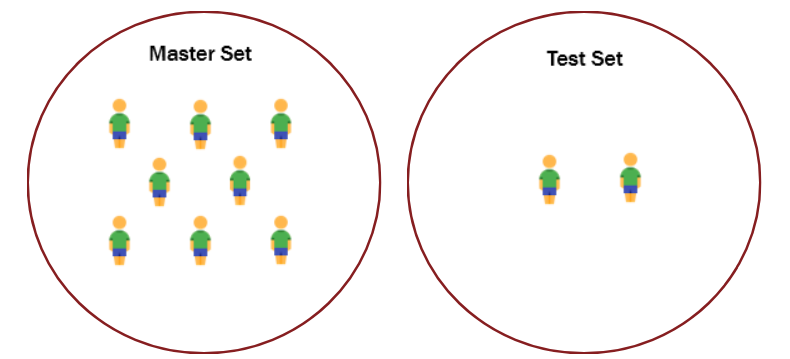

# assign subjects 1 - 8 to Master Set & 9 - 10 to Test Set​

In [65]:
master = masterset(subject_index_list = [1, 2, 3, 4, 5, 6, 7, 8])

1
2
3
4
5
6
7
8


In [66]:
test = testset(subject_index_list = [9, 10])

9
10


# Data cleaning: remove idle action = 0

![title](img/datacleaning.png)

In [67]:
master.data_cleaning()

before cleaning [ 0  1  2  3  4  6  7  8  9 10 11 12  5]
after cleaning [ 1  2  3  4  6  7  8  9 10 11 12  5]


In [68]:
test.data_cleaning()

before cleaning [ 0  1  2  3  4  6  7  8  9 10 11 12  5]
after cleaning [ 1  2  3  4  6  7  8  9 10 11 12  5]


# Dataset Description

2) Activity set

The activity set is listed in the following:

L1: Standing still (1 min) 
L2: Sitting and relaxing (1 min) 
L3: Lying down (1 min) 
L4: Walking (1 min) 
L5: Climbing stairs (1 min) 
L6: Waist bends forward (20x) 
L7: Frontal elevation of arms (20x)
L8: Knees bending (crouching) (20x)
L9: Cycling (1 min)
L10: Jogging (1 min)
L11: Running (1 min)
L12: Jump front & back (20x)

# masterset and testset rows and columns are as follows: 
### 25 columns, 23 are features
### Label = subjects movement
### subject = subject identity

![title](img/datadescription.png)

# The code to get dataset descriptive figures is as follows

# Master and test datasets size

In [69]:
master.get_data().shape

(275151, 25)

In [70]:
test.get_data().shape

(68044, 25)

# Original features in master and test sets

In [71]:
master.get_data().columns

Index(['AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ',
       'Label', 'Subject'],
      dtype='object')

# You can select any variables you want as features (Label and Subject columns must be included).  All original features in XYZ as well as Label and Subject are selected in our case

In [72]:
master.data_selected_features(['Label', 'Subject','AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ'
       ])

before features selected Index(['AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ',
       'Label', 'Subject'],
      dtype='object')
after features selected Index(['Label', 'Subject', 'AccelerationChestX', 'AccelerationChestY',
       'AccelerationChestZ', 'ElectrocardiogramLead1',
       'ElectrocardiogramLead2', 'AccelerationAnkleX', 'AccelerationAnkleY',
       'AccelerationAnkleZ', 'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ',
       'MagnetometerAnkleX', 'MagnetometerAnkleY', 'MagnetometerAnkleZ',
       'AccelerationArmX', 'AccelerationArmY', 'Accelerat

In [73]:
test.data_selected_features(['Label', 'Subject','AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ'
       ])

before features selected Index(['AccelerationChestX', 'AccelerationChestY', 'AccelerationChestZ',
       'ElectrocardiogramLead1', 'ElectrocardiogramLead2',
       'AccelerationAnkleX', 'AccelerationAnkleY', 'AccelerationAnkleZ',
       'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ', 'MagnetometerAnkleX',
       'MagnetometerAnkleY', 'MagnetometerAnkleZ', 'AccelerationArmX',
       'AccelerationArmY', 'AccelerationArmZ', 'GyroArmX', 'GyroArmY',
       'GyroArmZ', 'MagnetometerArmX', 'MagnetometerArmY', 'MagnetometerArmZ',
       'Label', 'Subject'],
      dtype='object')
after features selected Index(['Label', 'Subject', 'AccelerationChestX', 'AccelerationChestY',
       'AccelerationChestZ', 'ElectrocardiogramLead1',
       'ElectrocardiogramLead2', 'AccelerationAnkleX', 'AccelerationAnkleY',
       'AccelerationAnkleZ', 'GyroAnkleX', 'GyroAnkleY', 'GyroAnkleZ',
       'MagnetometerAnkleX', 'MagnetometerAnkleY', 'MagnetometerAnkleZ',
       'AccelerationArmX', 'AccelerationArmY', 'Accelerat

# First 5 observations of master and test sets

In [74]:
master.get_data().head()

,Label,Subject,AccelerationChestX,AccelerationChestY,AccelerationChestZ,ElectrocardiogramLead1,ElectrocardiogramLead2,AccelerationAnkleX,AccelerationAnkleY,AccelerationAnkleZ,...,MagnetometerAnkleZ,AccelerationArmX,AccelerationArmY,AccelerationArmZ,GyroArmX,GyroArmY,GyroArmZ,MagnetometerArmX,MagnetometerArmY,MagnetometerArmZ
6656,1,1,-9.7788,0.5569,1.1975,0.0084,-0.0335,2.6493,-9.4517,0.3768,...,-0.7382,-2.8439,-9.0618,1.8177,-0.0588,-0.9343,-0.3448,0.3554,-0.3700,-0.3502
6657,1,1,-9.7733,0.2788,0.7304,-0.0251,-0.0251,2.4157,-9.5306,0.4018,...,-0.8863,-2.9935,-9.2048,1.5189,-0.0588,-0.9343,-0.3448,0.7199,0.1780,0.3736
6658,1,1,-9.8609,0.1156,0.7999,0.0251,0.0167,2.3865,-9.5991,0.4814,...,-1.0198,-2.8846,-9.1945,1.5507,-0.0588,-0.9343,-0.3448,0.3554,-0.3700,-0.3502
6659,1,1,-9.7409,0.1765,0.8896,0.1800,0.1298,2.3758,-9.5997,0.4292,...,-1.1715,-2.9245,-9.1746,1.5413,-0.0784,-0.9343,-0.3405,0.3572,-0.1886,-0.3520
6660,1,1,-9.7821,0.2164,0.9037,0.0921,0.0460,2.3239,-9.5406,0.4004,...,-0.8863,-2.8963,-9.2039,1.6127,-0.0784,-0.9343,-0.3405,-0.0019,-0.1887,-0.7202


In [75]:
test.get_data().head()

,Label,Subject,AccelerationChestX,AccelerationChestY,AccelerationChestZ,ElectrocardiogramLead1,ElectrocardiogramLead2,AccelerationAnkleX,AccelerationAnkleY,AccelerationAnkleZ,...,MagnetometerAnkleZ,AccelerationArmX,AccelerationArmY,AccelerationArmZ,GyroArmX,GyroArmY,GyroArmZ,MagnetometerArmX,MagnetometerArmY,MagnetometerArmZ
12288,1,9,-9.4805,-1.7301,-0.1031,-0.7535,-0.5023,0.7906,-9.7829,0.9146,...,-0.4477,-2.7267,-9.0376,1.2356,-0.8078,-0.7023,-0.1530,0.0089,0.8892,-1.8138
12289,1,9,-9.4886,-1.8315,-0.0806,-0.2888,-0.1256,0.8035,-9.9303,1.0324,...,-0.5812,-2.7424,-9.3879,1.2077,-0.8078,-0.7023,-0.1530,-0.1742,0.5281,-1.8138
12290,1,9,-9.9525,-1.8703,0.3054,-0.0419,-0.0042,0.7197,-9.7724,0.9769,...,-0.2979,-2.7871,-8.9777,1.2282,-0.8078,-0.6899,-0.1595,0.3662,0.7115,-1.0828
12291,1,9,-9.5801,-1.8014,-0.1516,0.0251,0.0377,0.7519,-9.9608,0.9470,...,-0.5848,-2.9003,-9.2391,1.0901,-0.8078,-0.6899,-0.1595,0.1884,0.8839,-2.1711
12292,1,9,-9.2542,-1.9377,-0.3323,0.0921,0.0921,0.7309,-9.8915,0.9502,...,-0.4441,-2.9607,-9.2091,1.0916,-0.8078,-0.6899,-0.1595,0.3697,1.0671,-1.8083


# Brief descriptive figures of master and test sets

In [76]:
master.get_data().describe()

,Label,Subject,AccelerationChestX,AccelerationChestY,AccelerationChestZ,ElectrocardiogramLead1,ElectrocardiogramLead2,AccelerationAnkleX,AccelerationAnkleY,AccelerationAnkleZ,...,MagnetometerAnkleZ,AccelerationArmX,AccelerationArmY,AccelerationArmZ,GyroArmX,GyroArmY,GyroArmZ,MagnetometerArmX,MagnetometerArmY,MagnetometerArmZ
count,"275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000",...,"275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000"
mean,6.1691,4.4451,-7.5211,-0.1439,-0.6991,0.0005,-0.0103,1.8122,-9.0611,-0.7190,...,-0.2910,-3.3045,-5.8361,2.4530,-0.2087,-0.3975,0.3796,-0.5073,1.5699,0.3791
std,3.2949,2.2908,5.7563,2.6423,4.6355,0.9023,0.9316,4.1569,5.1818,6.4510,...,19.6150,5.9376,6.6136,4.2885,0.5396,0.5575,0.5200,34.4437,31.8531,84.8646
min,1.0000,1.0000,-22.4380,-20.1880,-18.4010,-8.6196,-8.6196,-22.1460,-19.6190,-19.3730,...,-282.3900,-22.3450,-18.9720,-18.2380,-1.1706,-2.2053,-1.1142,-319.0300,-358.1300,-702.5700
25%,3.0000,2.0000,-9.7301,-1.1886,-3.4634,-0.2303,-0.1884,0.1332,-10.0670,-3.4646,...,-1.7983,-4.8971,-9.5871,0.3530,-0.6412,-0.8337,-0.0388,-6.7149,-7.6942,-12.5520
50%,6.0000,4.0000,-8.8318,-0.2902,-0.6426,-0.0754,-0.0502,1.4497,-9.5854,0.2905,...,-0.2979,-2.3009,-7.7489,1.9991,-0.2941,-0.5934,0.4547,0.3590,0.3537,-0.4947
75%,9.0000,6.0000,-5.3472,0.8758,1.3605,0.1758,0.1549,2.9272,-7.4907,1.8118,...,1.5539,-0.3889,-2.1816,5.2345,0.1863,-0.0226,0.8448,5.5247,9.2660,11.2330
max,12.0000,8.0000,19.0940,20.9170,26.1960,8.5065,8.5191,20.0240,21.1610,25.0150,...,272.5600,19.8010,21.9650,25.7410,1.3216,1.1211,1.5280,234.8900,335.2500,657.1800


In [77]:
test.get_data().describe()

,Label,Subject,AccelerationChestX,AccelerationChestY,AccelerationChestZ,ElectrocardiogramLead1,ElectrocardiogramLead2,AccelerationAnkleX,AccelerationAnkleY,AccelerationAnkleZ,...,MagnetometerAnkleZ,AccelerationArmX,AccelerationArmY,AccelerationArmZ,GyroArmX,GyroArmY,GyroArmZ,MagnetometerArmX,MagnetometerArmY,MagnetometerArmZ
count,"68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000",...,"68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000","68,044.0000"
mean,6.1685,9.4951,-7.3403,-0.1291,-1.9060,0.0164,0.0009,1.7767,-9.0630,-0.6332,...,-0.7398,-4.0294,-5.5605,2.0906,-0.1726,-0.4630,0.3852,-0.6352,0.8247,-1.3784
std,3.3150,0.5000,5.4742,3.3606,4.3803,0.5082,0.4485,4.4382,5.2750,6.4838,...,15.6655,5.6648,6.4292,3.6834,0.5869,0.4953,0.4979,33.2808,22.8651,73.0708
min,1.0000,9.0000,-22.2960,-20.0210,-18.4000,-3.6044,-4.6007,-22.1260,-19.5990,-19.3640,...,-203.5500,-21.9050,-18.9280,-18.2160,-1.0608,-2.2567,-0.8707,-207.9200,-316.2300,-504.8000
25%,3.0000,9.0000,-9.6199,-1.8831,-4.7368,-0.1591,-0.1256,0.2261,-10.0520,-3.5820,...,-1.6146,-5.6871,-9.4601,-0.2312,-0.7294,-0.7885,-0.0453,-4.7768,-5.9813,-10.9930
50%,6.0000,9.0000,-8.5835,-0.3034,-1.8136,-0.0670,-0.0460,0.9679,-9.6711,0.4872,...,-0.4423,-2.9272,-7.7009,1.0524,-0.3863,-0.6140,0.4440,0.3626,0.3557,-0.7165
75%,9.0000,10.0000,-4.6367,1.8098,0.1313,0.1298,0.0921,2.8742,-8.1240,1.9304,...,1.6242,-1.5323,-2.4226,5.8657,0.4098,-0.1232,0.8147,4.2132,5.6830,7.1573
max,12.0000,10.0000,17.6180,20.9270,10.5620,4.0816,4.6845,20.0140,20.7660,24.4000,...,179.7300,19.3980,21.8070,23.9740,1.4157,0.6838,1.3772,239.6900,221.0100,586.0800


# 12 Actions are included in the datasets

In [78]:
master.get_selected_labels()

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12,  5], dtype=int64)

In [79]:
test.get_selected_labels()

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12,  5], dtype=int64)

In [80]:
print(master.get_data().shape)
print(test.get_data().shape)

(275151, 25)
(68044, 25)


In [81]:
len(master.get_selected_labels())

12

# Number of observations of 12 actions for subject 9 and 10

In [82]:
test.get_data().groupby(by = ['Subject','Label']).count()

AccelerationChestX  AccelerationChestY  AccelerationChestZ  \
Subject Label                                                               
9       1                    3072                3072                3072   
        2                    3072                3072                3072   
        3                    3072                3072                3072   
        4                    3072                3072                3072   
        5                    3072                3072                3072   
        6                    2867                2867                2867   
        7                    2867                2867                2867   
        8                    2969                2969                2969   
        9                    3072                3072                3072   
        10                   3072                3072                3072   
        11                   3072                3072                3072   
        12                   1075                1075                1075   
10      1                    3072                3072                3072   
        2                    3072                3072                3072   
        3                    3072                3072                3072   
        4                    3072                3072                3072   
        5                    3072                3072                3072   
        6                    2458                2458                2458   
        7                    2765                2765                2765   
        8                    2867                2867                2867   
        9                    3072                3072                3072   
        10                   3072                3072                3072   
        11                   3072                3072                3072   
        12                   1024                1024                1024   

               ElectrocardiogramLead1  ElectrocardiogramLead2  \
Subject Label                                                   
9       1                        3072                    3072   
        2                        3072                    3072   
        3                        3072                    3072   
        4                        3072                    3072   
        5                        3072                    3072   
        6                        2867                    2867   
        7                        2867                    2867   
        8                        2969                    2969   
        9                        3072                    3072   
        10                       3072                    3072   
        11                       3072                    3072   
        12                       1075                    1075   
10      1                        3072                    3072   
        2                        3072                    3072   
        3                        3072                    3072   
        4                        3072                    3072   
        5                        3072                    3072   
        6                        2458                    2458   
        7                        2765                    2765   
        8                        2867                    2867   
        9                        3072                    3072   
        10                       3072                    3072   
        11                       3072                    3072   
        12                       1024                    1024   

               AccelerationAnkleX  AccelerationAnkleY  AccelerationAnkleZ  \
Subject Label                                                               
9       1                    3072                3072                3072   
        2                    3072                3072                3072   
        3    

# Dynamic Time Warping with Feature Extraction

# we will apply two machine learning technqiues (1. scaling and 2. dimension reduction) to master and test set before performing classification by Dynamic Time Warping

### Scaling = Normalization
### Dimension reduction = Principal Component Analysis

### Pass in master and test set to initialize DTW experiment object

In [83]:
dtw_experiment = DTWExperiment(master, test)

# Scaling by Normalization

### As you can see, 23 features have different scales e.g. max of MagnetoMeterArmX = 234.89 whereas max of GyroArmX = 1.326 
### Machine learning models may have a bias to the features those are with larger scales.  
### Therefore, we rescale all 23 features by normalization

In [84]:
dtw_experiment.get_masterset().get_data().describe()

,Label,Subject,AccelerationChestX,AccelerationChestY,AccelerationChestZ,ElectrocardiogramLead1,ElectrocardiogramLead2,AccelerationAnkleX,AccelerationAnkleY,AccelerationAnkleZ,...,MagnetometerAnkleZ,AccelerationArmX,AccelerationArmY,AccelerationArmZ,GyroArmX,GyroArmY,GyroArmZ,MagnetometerArmX,MagnetometerArmY,MagnetometerArmZ
count,"275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000",...,"275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000","275,151.0000"
mean,6.1691,4.4451,-7.5211,-0.1439,-0.6991,0.0005,-0.0103,1.8122,-9.0611,-0.7190,...,-0.2910,-3.3045,-5.8361,2.4530,-0.2087,-0.3975,0.3796,-0.5073,1.5699,0.3791
std,3.2949,2.2908,5.7563,2.6423,4.6355,0.9023,0.9316,4.1569,5.1818,6.4510,...,19.6150,5.9376,6.6136,4.2885,0.5396,0.5575,0.5200,34.4437,31.8531,84.8646
min,1.0000,1.0000,-22.4380,-20.1880,-18.4010,-8.6196,-8.6196,-22.1460,-19.6190,-19.3730,...,-282.3900,-22.3450,-18.9720,-18.2380,-1.1706,-2.2053,-1.1142,-319.0300,-358.1300,-702.5700
25%,3.0000,2.0000,-9.7301,-1.1886,-3.4634,-0.2303,-0.1884,0.1332,-10.0670,-3.4646,...,-1.7983,-4.8971,-9.5871,0.3530,-0.6412,-0.8337,-0.0388,-6.7149,-7.6942,-12.5520
50%,6.0000,4.0000,-8.8318,-0.2902,-0.6426,-0.0754,-0.0502,1.4497,-9.5854,0.2905,...,-0.2979,-2.3009,-7.7489,1.9991,-0.2941,-0.5934,0.4547,0.3590,0.3537,-0.4947
75%,9.0000,6.0000,-5.3472,0.8758,1.3605,0.1758,0.1549,2.9272,-7.4907,1.8118,...,1.5539,-0.3889,-2.1816,5.2345,0.1863,-0.0226,0.8448,5.5247,9.2660,11.2330
max,12.0000,8.0000,19.0940,20.9170,26.1960,8.5065,8.5191,20.0240,21.1610,25.0150,...,272.5600,19.8010,21.9650,25.7410,1.3216,1.1211,1.5280,234.8900,335.2500,657.1800


In [85]:
dtw_experiment.get_masterset().get_data().describe()[['GyroArmX','MagnetometerArmX']]

,GyroArmX,MagnetometerArmX
count,"275,151.0000","275,151.0000"
mean,-0.2087,-0.5073
std,0.5396,34.4437
min,-1.1706,-319.0300
25%,-0.6412,-6.7149
50%,-0.2941,0.3590
75%,0.1863,5.5247
max,1.3216,234.8900


# Normalization will be applied in every column individually by substracting its mean and dividing by its standard deviation (basically it's z-value), so that all features end up to be in same scale.  

## Zij = (Xij – Mean of Xi) / S.D. of Xi

## For details, please see Method dtw_experiment.Scaling() and StandardScaler() in sklearn link below

## http://scikit-learn.org/stable/modules/preprocessing.html

## Remarks: you may get confused by the name "Normalization" and the method StandardScaler() in sklearn.  I have no idea why sklearn named the method as StandardScaler(), but in statistics, we call this as normalization.  So, to be consistent, I think we will just stick to "Normalization"

## https://en.wikipedia.org/wiki/Normalization_(statistics)

In [86]:
dtw_experiment.restoringDataset()

In [87]:
dtw_experiment.Scaling(preprocessing.StandardScaler())

(275151, 23)
(275151,)


# After rescaling, all 23 features are in same scale

In [88]:
dtw_experiment.get_masterset().get_data().head()

,AccelerationChestX,AccelerationChestY,AccelerationChestZ,ElectrocardiogramLead1,ElectrocardiogramLead2,AccelerationAnkleX,AccelerationAnkleY,AccelerationAnkleZ,GyroAnkleX,GyroAnkleY,...,AccelerationArmY,AccelerationArmZ,GyroArmX,GyroArmY,GyroArmZ,MagnetometerArmX,MagnetometerArmY,MagnetometerArmZ,Subject,Label
0,-0.3922,0.2652,0.4092,0.0087,-0.0249,0.2014,-0.0754,0.1699,-0.6165,-0.7794,...,-0.4877,-0.1481,0.2778,-0.9628,-1.3932,0.0250,-0.0609,-0.0086,1,1
1,-0.3913,0.1600,0.3084,-0.0284,-0.0160,0.1452,-0.0906,0.1737,-0.6165,-0.7794,...,-0.5094,-0.2178,0.2778,-0.9628,-1.3932,0.0356,-0.0437,-0.0001,1,1
2,-0.4065,0.0982,0.3234,0.0273,0.0290,0.1381,-0.1038,0.1861,-0.5967,-0.7322,...,-0.5078,-0.2104,0.2778,-0.9628,-1.3932,0.0250,-0.0609,-0.0086,1,1
3,-0.3856,0.1212,0.3427,0.1989,0.1503,0.1356,-0.1039,0.1780,-0.5967,-0.7322,...,-0.5048,-0.2126,0.2415,-0.9628,-1.3849,0.0251,-0.0552,-0.0086,1,1
4,-0.3928,0.1363,0.3458,0.1015,0.0604,0.1231,-0.0925,0.1735,-0.5967,-0.7322,...,-0.5092,-0.1960,0.2415,-0.9628,-1.3849,0.0147,-0.0552,-0.0130,1,1


In [89]:
dtw_experiment.get_testset().get_data().head()

,AccelerationChestX,AccelerationChestY,AccelerationChestZ,ElectrocardiogramLead1,ElectrocardiogramLead2,AccelerationAnkleX,AccelerationAnkleY,AccelerationAnkleZ,GyroAnkleX,GyroAnkleY,...,AccelerationArmY,AccelerationArmZ,GyroArmX,GyroArmY,GyroArmZ,MagnetometerArmX,MagnetometerArmY,MagnetometerArmZ,Subject,Label
0,-0.3404,-0.6003,0.1286,-0.8356,-0.5282,-0.2458,-0.1393,0.2532,-1.4032,-0.5133,...,-0.4841,-0.2839,-1.1102,-0.5466,-1.0243,0.0150,-0.0214,-0.0258,9,1
1,-0.3418,-0.6387,0.1334,-0.3207,-0.1238,-0.2427,-0.1677,0.2715,-1.4032,-0.5133,...,-0.5370,-0.2904,-1.1102,-0.5466,-1.0243,0.0097,-0.0327,-0.0258,9,1
2,-0.4224,-0.6534,0.2167,-0.0470,0.0065,-0.2628,-0.1373,0.2629,-1.4032,-0.5133,...,-0.4750,-0.2856,-1.1102,-0.5245,-1.0367,0.0254,-0.0269,-0.0172,9,1
3,-0.3577,-0.6273,0.1181,0.0273,0.0515,-0.2551,-0.1736,0.2583,-1.4032,-0.5133,...,-0.5145,-0.3178,-1.1102,-0.5245,-1.0367,0.0202,-0.0215,-0.0301,9,1
4,-0.3011,-0.6789,0.0791,0.1015,0.1099,-0.2601,-0.1603,0.2588,-1.3595,-0.4919,...,-0.5100,-0.3175,-1.1102,-0.5245,-1.0367,0.0255,-0.0158,-0.0258,9,1


# After rescaling, all 23 features are in same scale with zero mean and one s.d.

In [90]:
pd.options.display.float_format = '{:,.4f}'.format

In [91]:
dtw_experiment.get_masterset().get_data().describe()[['GyroArmX','MagnetometerArmX']]

,GyroArmX,MagnetometerArmX
count,"275,151.0000","275,151.0000"
mean,-0.0000,-0.0000
std,1.0000,1.0000
min,-1.7824,-9.2477
25%,-0.8014,-0.1802
50%,-0.1582,0.0251
75%,0.7320,0.1751
max,2.8358,6.8343


# Reducing Dimension by Principal Component Analysis

# Why Dimension Reduction?

### - 23 features in our dataset which is too much

### - Rule of thumb: Prefer important but small no. of features rather than unimportant but large no. of features 

### - Curse of dimensionality: Some supervised models such as multiple linear regression, it has assumptions that the no. of observations has to be more than no. of features 

### - Collinearity: if Corr(A, B) = 0.99, A is simply equal to B.  Thus, either A or B is used

### - Increase processing speed

### https://en.wikipedia.org/wiki/Curse_of_dimensionality



## Principal Component Analysis (PCA) is used to reduce dimension

# Principal Component Analysis (PCA)

### - Set complex mathematical formula aside, what is PCA?

### - We focus on application of PCA and explain its characteristics by our friend 3D Armadillo below




# If we transform our friend 3D armadillo to a 2D image by using the "first two principal components"? What will it look like?

<table>
  <tr>
    <th>
X = Depth;
Y = Width;
Z = Height;
     
      </th>
    <th>![title](img/armadillo_3D.png)</th>
  </tr>
  
</table>

<table>
  <tr>
    <th>![title](img/a_his_beach_pic.png)</th>
    <th>![title](img/b_his_car_accident_pic.png)</th>
    <th>![title](img/c_his_embarrassing_pic.png)</th>
    
  </tr>
  
</table>

# The answer is b

<table>
  <tr>
    <th>![title](img/a_his_beach_pic_ans.png)</th>
    <th>![title](img/b_his_car_accident_pic_ans.png)</th>
    <th>![title](img/c_his_embarrassing_pic_ans.png)</th>
    
  </tr>
  
</table>

# Through this question, we understand the characteristics of PCA are that​

### - If we have 3 features, we will have 3 corresponding principal components (p.c.)​

### - PCA will prioritize principal components by the volume of information they contain​

### - Height factor contains the most information, then width factor. Depth factor contains the least information.​

# Reducing dimension by PCA using 8 components


### In practice, we select a number of principal components with explained variance >= 1
### therefore in our case, K = 8 principal components are selected
### cumulative variance explained = 62%

## http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

[0.14678079 0.09577348 0.08202411 0.06857537 0.06431612 0.0633981
 0.05471197 0.05007885 0.04435145 0.0418714  0.03721975 0.03405824
 0.03255297 0.03017873 0.02633779 0.02226101 0.02098988 0.02063281
 0.01890486 0.01521238 0.01195803 0.0097744  0.00803754]
[3.37597049 2.20279807 1.88656142 1.57723916 1.47927606 1.45816161
 1.25837978 1.15181762 1.02008694 0.96304575 0.85605743 0.78334235
 0.748721   0.69411324 0.60577127 0.5120052  0.48276901 0.47455632
 0.43481332 0.34988596 0.27503558 0.22481196 0.18486404]
Cummulative Variance Explained =  0.9999999999999998
[3.37597049 2.20279807 1.88656142 1.57723916 1.47927606 1.45816161
 1.25837978 1.15181762 1.02008694 0.96304575 0.85605743 0.78334235
 0.748721   0.69411324 0.60577127 0.5120052  0.48276901 0.47455632
 0.43481332 0.34988596 0.27503558 0.22481196 0.18486404]
suggestedDimensions 1
suggestedDimensions 2
suggestedDimensions 3
suggestedDimensions 4
suggestedDimensions 5
suggestedDimensions 6
suggestedDimensions 7
suggestedDimensions 

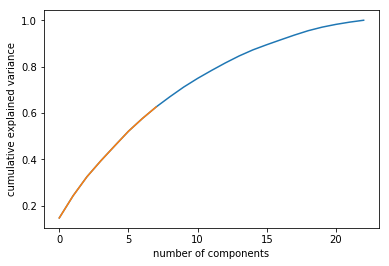

In [92]:
dtw_experiment.ReducingDimensionByPCA()

# The Dimension has been reduced to 8 features as shown below

In [93]:
dtw_experiment.get_masterset().get_data().head()

,0,1,2,3,4,5,6,7,Subject,Label
0,1.4205,0.1461,0.5278,-0.3878,-0.1636,-0.6580,-0.0799,0.8654,1,1
1,1.4677,0.1327,0.5336,-0.3475,-0.1288,-0.6374,-0.0327,0.9049,1,1
2,1.4337,0.1360,0.5155,-0.3965,-0.0728,-0.6211,-0.0360,0.9318,1,1
3,1.4356,0.1503,0.5072,-0.5479,0.0508,-0.6012,-0.0610,0.8618,1,1
4,1.4311,0.1508,0.5146,-0.4496,-0.0286,-0.6186,-0.0407,0.8873,1,1


In [94]:
dtw_experiment.get_testset().get_data().head()

,0,1,2,3,4,5,6,7,Subject,Label
0,0.8550,0.0164,1.5135,1.1538,0.6332,-0.5709,0.8239,0.4245,9,1
1,0.8899,0.0326,1.4288,0.6667,1.0194,-0.4944,0.7568,0.3094,9,1
2,0.8507,0.0588,1.4215,0.4510,1.1795,-0.4321,0.7518,0.2644,9,1
3,0.9129,0.0415,1.4057,0.3884,1.2253,-0.4391,0.7176,0.2125,9,1
4,0.8917,0.0446,1.3818,0.3085,1.2737,-0.4308,0.7000,0.2105,9,1


# There is nothing changed in our dataset except that the 23 features have been transformed to 8 factors

![title](img/after_dimension_reduction.png)

# Classification by Dynamic Time Warping

# We select an unknown action 3 of subject 9 in test set (but we know the action is lying down)​

# Use DTW to find distance between the unknown action and 12 actions of subject 1 from master set
![title](img/compare_1_subject.png)

### given:
### Method = classifyOneMovement
### Test subject = 9
### Test subject action = 3
### subsample = 5 (for both masterset and testset)

### Subsample means that every 5 observations we take 1 observation as sample data

In [95]:
one_move_df = dtw_experiment.classifyOneMovement(mastersubject_index = 1
                                                  , testsubject_index = 9
                                                  , testsubject_action_index = 3
                                                  , subsample = 5)

In [96]:
one_move_df

,MasterSubject,TestSubject,TestSubjectAction,MasterSetAction,Distance,isMinDistance,isCorrect
0,1,9,3,1,"4,230.2542",0.0000,0.0000
1,1,9,3,2,"3,598.7247",0.0000,0.0000
2,1,9,3,3,823.5941,1.0000,1.0000
3,1,9,3,4,"3,840.9961",0.0000,0.0000
4,1,9,3,6,"4,099.4857",0.0000,0.0000
5,1,9,3,7,"3,502.3521",0.0000,0.0000
6,1,9,3,8,"4,800.8909",0.0000,0.0000
7,1,9,3,9,"3,705.2813",0.0000,0.0000
8,1,9,3,10,"4,378.7362",0.0000,0.0000
9,1,9,3,11,"5,773.2497",0.0000,0.0000


# As a result, we find that action 3 of subject 1 has the shortest distance with this unknown action

In [97]:
one_move_df[one_move_df['isMinDistance']==1]

,MasterSubject,TestSubject,TestSubjectAction,MasterSetAction,Distance,isMinDistance,isCorrect
2,1,9,3,3,823.5941,1.0000,1.0000


# Instead of just comparing the unknown action with one subject in master set, we compare all 8 subjects in master set to find everyone of their actions' distance

![title](img/compare_8_subjects.png)

### given:
### Method = classifyOneMovementByAllMasterSubjects
### Test subject = 9
### Test subject action = 3
### subsample = 5 (for both masterset and testset)

In [98]:
one_move_all_df = dtw_experiment.classifyOneMovementByAllMasterSubjects(testsubject_index = 9
                                                                          , testsubject_action_index = 3
                                                                          , subsample = 5)

In [99]:
one_move_all_df

,MasterSubject,TestSubject,TestSubjectAction,MasterSetAction,Distance,isMinDistance,isCorrect
0,1,9,3,1,"4,230.2542",0.0000,0.0000
1,1,9,3,2,"3,598.7247",0.0000,0.0000
2,1,9,3,3,823.5941,1.0000,1.0000
3,1,9,3,4,"3,840.9961",0.0000,0.0000
4,1,9,3,6,"4,099.4857",0.0000,0.0000
5,1,9,3,7,"3,502.3521",0.0000,0.0000
6,1,9,3,8,"4,800.8909",0.0000,0.0000
7,1,9,3,9,"3,705.2813",0.0000,0.0000
8,1,9,3,10,"4,378.7362",0.0000,0.0000
9,1,9,3,11,"5,773.2497",0.0000,0.0000


# We make a prediction of unknown action by using the mean distance of selective actions (12 actions in our case) in master subjects (8 subjects)

In [100]:
one_move_all_df[['MasterSetAction','Distance']].groupby(by="MasterSetAction").mean()

,Distance
MasterSetAction,
1,"3,874.6895"
2,"3,591.7297"
3,"1,204.2421"
4,"4,074.3209"
5,"4,032.5365"
6,"4,480.3591"
7,"3,509.3477"
8,"4,515.9039"
9,"3,937.3700"


# As you can see, the mean distance of action 3 has the shortest mean distance, thus we predict that the unknown action is action 3 (lying down)

In [ ]:
one_move_all_df[['MasterSetAction','Distance']].groupby(by="MasterSetAction").mean().idxmin().values[0]

3

# We directly get the prediction by method called "predictOneMovement"

In [ ]:
predictedAction, predictedResult = dtw_experiment.predictOneMovement(testsubject_index = 9
                                                  , testsubject_action_index = 3
                                                  , subsample = 5)

In [ ]:
predictedAction

In [ ]:
predictedResult

# Repeat same steps for remaining actions of the 2 subjects in Test Set

![title](img/compare_all.png)

In [49]:
predicted_all_df, accuracy = dtw_experiment.PredictAllMovements(test_subject_index_list = [9, 10]
                                                   , test_subject_action_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
                                                   , subsample = 5)


In [50]:
accuracy

0.625

In [51]:
predicted_all_df

,TestSubject,ActualAction,PredictedAction,Result
0,9,1,1,True
1,9,2,7,False
2,9,3,3,True
3,9,4,4,True
4,9,5,5,True
5,9,6,8,False
6,9,7,9,False
7,9,8,9,False
8,9,9,9,True
9,9,10,10,True


2) Activity set

The activity set is listed in the following:

L1: Standing still (1 min) 
L2: Sitting and relaxing (1 min) 
L3: Lying down (1 min) 
L4: Walking (1 min) 
L5: Climbing stairs (1 min) 
L6: Waist bends forward (20x) 
L7: Frontal elevation of arms (20x)
L8: Knees bending (crouching) (20x)
L9: Cycling (1 min)
L10: Jogging (1 min)
L11: Running (1 min)
L12: Jump front & back (20x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

            Standing       1.00      1.00      1.00         2
             Sitting       1.00      0.50      0.67         2
               Lying       1.00      1.00      1.00         2
             Walking       1.00      1.00      1.00         2
            Climbing       1.00      1.00      1.00         2
   WaistBendsForward       0.00      0.00      0.00         2
FrontalEvelationArms       0.00      0.00      0.00         2
           Crouching       0.00      0.00      0.00         2
             Cycling       0.33      1.00      0.50         2
             Jogging       0.50      1.00      0.67         2
             Running       0.00      0.00      0.00         2
             Jumping       1.00      1.00      1.00         2

         avg / total       0.57      0.62      0.57        24



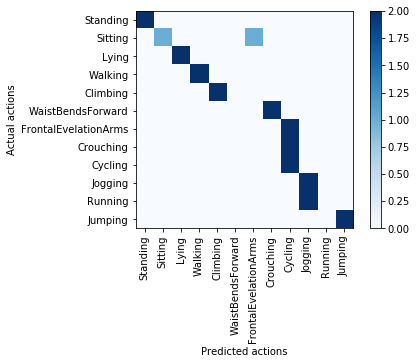

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics

columns = ['Standing', 'Sitting', 'Lying', 'Walking', 'Climbing', 'WaistBendsForward', 'FrontalEvelationArms'
          , 'Crouching','Cycling','Jogging','Running','Jumping']
confusion = metrics.confusion_matrix(predicted_all_df['ActualAction'], predicted_all_df['PredictedAction'])
print(metrics.classification_report(predicted_all_df['ActualAction'], predicted_all_df['PredictedAction'], target_names=columns))

plt.imshow(confusion, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], columns, rotation='vertical')
plt.xlabel('Predicted actions')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], columns)
plt.ylabel('Actual actions')
plt.colorbar()

plt.show()

# From the result above, we understand that
### - DTW can be used for classification problems​

### - DTW does a pretty good job at identifying actions including standing, lying down, walking, climbing, cycling, jogging and jumping.​

### - Some actions such as WaistBendsForward and FrontalEvelationArms are difficult to be identified by DTW​

# Code for 3D armadillo case

### source: edX - Microsoft: DAT210x Programming with Python for Data Science - Lab4_1
### https://courses.edx.org/courses/course-v1:Microsoft+DAT210x+4T2017/course/

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData, PlyElement

plt.style.use('ggplot')

reduce_factor = 100

plyfile = PlyData.read('PCA/Datasets/stanford_armadillo.ply')

armadillo = pd.DataFrame({
  'x':plyfile['vertex']['z'][::reduce_factor],
  'y':plyfile['vertex']['x'][::reduce_factor],
  'z':plyfile['vertex']['y'][::reduce_factor]
})



In [54]:
def do_PCA(armadillo, n_components, svd_solver):
    # .. your code here ..
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=n_components, svd_solver=svd_solver)
    pca.fit(armadillo)
    T = pca.transform(armadillo)
    
    return T 

In [55]:
pca = do_PCA(armadillo, 3, 'full')

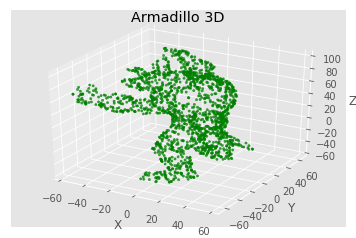

In [56]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

ax.set_title('Armadillo 3D')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.scatter(armadillo.x, armadillo.y, armadillo.z, c='green', marker='.', alpha=0.75)
plt.show()

# Get 3 images

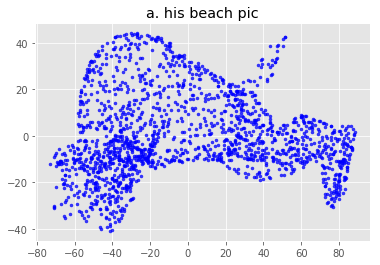

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('a. his beach pic')
ax.scatter(pca[:,0], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()

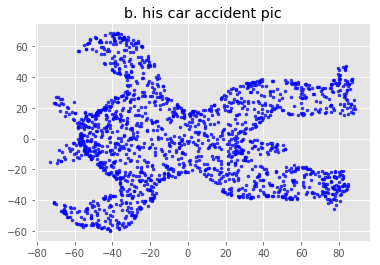

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('b. his car accident pic')
ax.scatter(pca[:,0], pca[:,1], c='blue', marker='.', alpha=0.75)
plt.show()

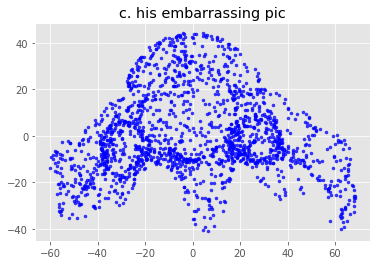

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('c. his embarrassing pic')
ax.scatter(pca[:,1], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()

# get components

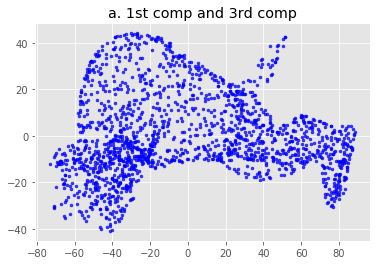

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('a. 1st comp and 3rd comp')
ax.scatter(pca[:,0], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()

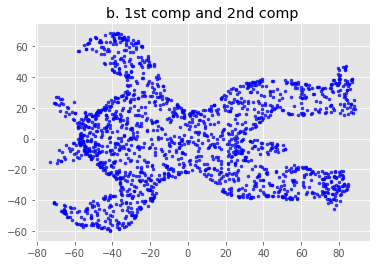

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('b. 1st comp and 2nd comp')
ax.scatter(pca[:,0], pca[:,1], c='blue', marker='.', alpha=0.75)
plt.show()

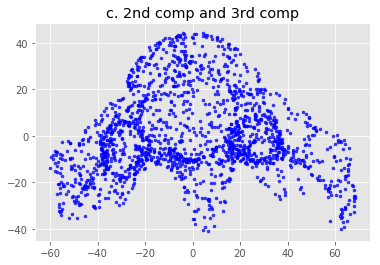

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('c. 2nd comp and 3rd comp')
ax.scatter(pca[:,1], pca[:,2], c='blue', marker='.', alpha=0.75)
plt.show()